# Spotify Natural Language Processing Project

### By: Daniel Ford, Glady Barrios, Kevin Smith

Kalpana Cohort 

Spetember 8, 2022

----

# Project Goal

- The goal of this project is to use natural language processing and classification models to identify terms for predicting a readme's primary language on Github.

---

# Inital Questions 

 - What are the top 5 programming languages when searching for 'Spotify' repos on github?
 - What are the most common words we would see when searching for spotify README's?
 - From these top 5 programing languages what are the most common words from these languages?
 - What are some common bigrams in the diffrent programming languages? 


### Mini-data dictionary

---
| Attribute | Definition | Data Type |
| ----- | ----- | ----- |
|Repo |The username of the REPO|object |
|readme_contents |What is inside the readme | object|
|language|the programming language |object |
|lemmatized|prepared data |object |


### Important Libraries

In [2]:
import pandas as pd
import numpy as np
import unicodedata
import re, os
import json
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline,Pipeline

import time
import random
from requests import get
from bs4 import BeautifulSoup
#the aquire takes a while
import acquire

import prepare

import warnings
warnings.filterwarnings("ignore")

# Acquire
---

To acquire the data first we needed to scrape the links for the individual repos from github by iterating through the pages of search results and grabbing the 10 links from each page. 

Once this step was completed we were able to populate a dataframe with the name of the repo, the main coding language, and the contents of the README file associated with the repo by utilizing different functions that gathered those pieces of data from the github API. 

Both process were wrapped in a TQDM progress bar because the acquisition took about 45 minutes altogether, and having a progress bar allowed us to know if the function was still working, or if it had timed out.

In [3]:
#aqcuiring the data by calling the function "github_df()" from our aquire file  
df = acquire.github_df()

Populating DataFrame:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
#.head() contains the first five rows of the dataset 
df.head()

,repo,language,readme_contents
0,zmb3/spotify,Go,\nSpotify\n=======\n\n[![GoDoc](https://godoc....
1,spotDL/spotify-downloader,Python,<!--- mdformat-toc start --slug=github --->\n\...
2,Spotifyd/spotifyd,Rust,# Spotifyd <!-- omit in toc -->\n<!-- ALL-CONT...
3,Rigellute/spotify-tui,Rust,# Spotify TUI\n\n![Continuous Integration](htt...
4,JohnnyCrazy/SpotifyAPI-NET,C#,"\n<h1 align=""center"">\n <p align=""center"">Spo..."


# Prepare 

In [6]:
#preparing the data by calling the function "prepare_df()" from our prepare.py file 
df= prepare.prepare_df(df,'readme_contents')

In [7]:
#lets look at the data now that it has been prepared
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,original_length,stem_length,lem_length,original_word_count,stemmed_word_count,lemmatized_word_count
0,zmb3/spotify,other,\nSpotify\n=======\n\n[![GoDoc](https://godoc....,spotify godochttpsgodocorggithubcomzmb3spotify...,spotifi godochttpsgodocorggithubcomzmb3spotify...,spotify godochttpsgodocorggithubcomzmb3spotify...,3918,2352,2640,503,276,276
1,spotDL/spotify-downloader,Python,<!--- mdformat-toc start --slug=github --->\n\...,mdformattoc start sluggithub editing readme en...,mdformattoc start sluggithub edit readm ensur ...,mdformattoc start sluggithub editing readme en...,4300,2834,3021,471,277,277
2,Spotifyd/spotifyd,other,# Spotifyd <!-- omit in toc -->\n<!-- ALL-CONT...,spotifyd omit toc allcontributorsbadgestart re...,spotifyd omit toc allcontributorsbadgestart re...,spotifyd omit toc allcontributorsbadgestart re...,2177,1482,1576,231,136,136
3,Rigellute/spotify-tui,other,# Spotify TUI\n\n![Continuous Integration](htt...,spotify tui continuous integrationhttpsgithubc...,spotifi tui continu integrationhttpsgithubcomr...,spotify tui continuous integrationhttpsgithubc...,59878,32960,34049,3857,2495,2495
4,JohnnyCrazy/SpotifyAPI-NET,C#,"\n<h1 align=""center"">\n <p align=""center"">Spo...",h1 aligncenter aligncenterspotifyapinetp hrefh...,h1 aligncent aligncenterspotifyapinetp hrefhtt...,h1 aligncenter aligncenterspotifyapinetp hrefh...,2782,1881,2009,272,169,169


### What we did to prepare the data

- lowercase the readme contents to avoid case sensitivity

- remove any inconsistencies in unicode character encoding

- remove special characters, such as non-alphanumeric characters that could cause extra noise

- tokenize the data

- stemming the data

- apply lemmatization

- remove unnecessary stopwords

- remove where the readme contents were null

- generate additional features for exploration and modeling such as README length and word counts 

## Split the data

In [8]:
#this will help us better explore the data
train, validate, test = prepare.train_validate_test_split(df)

In [9]:
train.shape, validate.shape, test.shape

((540, 12), (232, 12), (193, 12))

# Exploration 

## Question 1- What are the top 5 programming languages when searching for 'Spotify' repos on github?

In [10]:
df.language.value_counts()

other         354
JavaScript    282
Python        194
TypeScript     68
Shell          39
C#             28
Name: language, dtype: int64

#### Looks like the top 5 Programing languages are 

>- JavaScript 
>- Python
>- TypeScript
>- Shell
>- C#

## Question 2- What are the most common words we would see when searching for spotify README's?

In [11]:
labels2 = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
labels2.columns = ['n', 'percent']


In [12]:
Java_words = (' '.join(train[train.language == 'JavaScript'].lemmatized)).split()
python_words = (' '.join(train[train.language == 'Python'].lemmatized)).split()
type_words= (' '.join(train[train.language == 'TypeScript'].lemmatized)).split()
Shell_words= (' '.join(train[train.language == 'Shell'].lemmatized)).split()
c_words= (' '.join(train[train.language == 'C#'].lemmatized)).split()
all_words = (' '.join(train.lemmatized)).split()

In [13]:
Java_freq = pd.Series(Java_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
all_freq = pd.Series(all_words).value_counts()
type_freq = pd.Series(type_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
shell_freq = pd.Series(Shell_words).value_counts()

In [14]:
all_freq.head(10)

spotify     2962
track       1235
playlist    1215
use          862
song         850
install      809
user         805
api          774
run          772
get          766
dtype: int64

## Question 3- From these top 5 programing languages what are the most common words from these languages?

In [15]:
word_counts = (pd.concat([Java_freq, python_freq, all_freq, type_freq,c_freq, shell_freq], axis=1, sort=True)
              .set_axis(['java','python', 'all', 'TypeScript','C#', 'Shell'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [16]:
word_counts.sort_values(by='all', ascending=False).head(15)

,java,python,all,TypeScript,C#,Shell
spotify,683,655,2962,252,110,111
track,213,293,1235,129,75,20
playlist,189,456,1215,135,47,6
use,237,157,862,58,25,29
song,124,309,850,47,19,12
install,183,269,809,43,3,44
user,201,124,805,104,15,8
api,200,187,774,34,32,3
run,246,193,772,80,6,24
get,186,134,766,136,13,10


## Question 4 - What are some common bigrams in the diffrent programming languages?

## JAVA

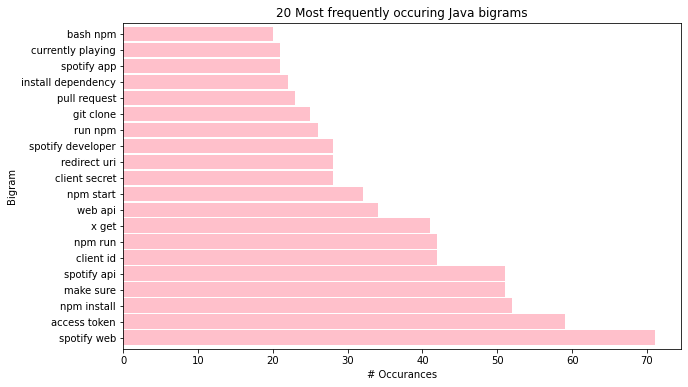

In [17]:
top_20_java_bigrams = (pd.Series(nltk.ngrams(Java_words, 2))
                      .value_counts()
                      .head(20))
top_20_java_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Java bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_java_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


## Python

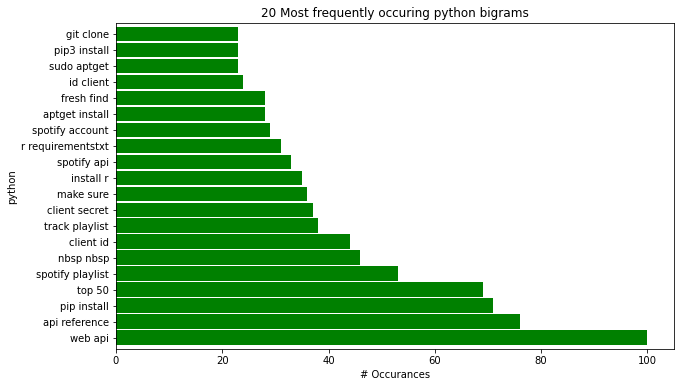

In [18]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.sort_values(ascending=False).plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('python')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## TypeScript

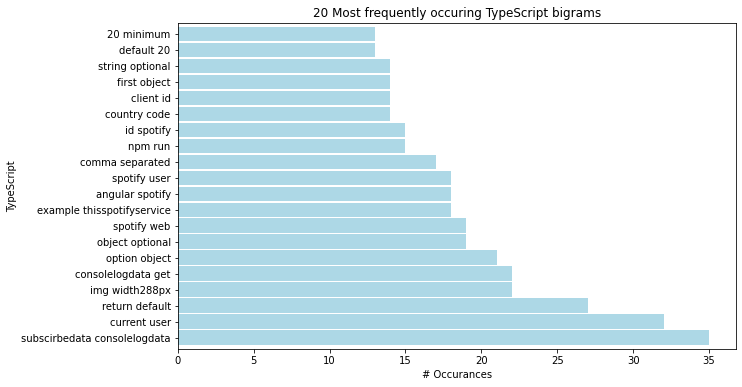

In [19]:
top_20_type_bigrams = (pd.Series(nltk.ngrams(type_words, 2))
                      .value_counts()
                      .head(20))

top_20_type_bigrams.sort_values(ascending=False).plot.barh(color='lightblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring TypeScript bigrams')
plt.ylabel('TypeScript')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_type_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## C#

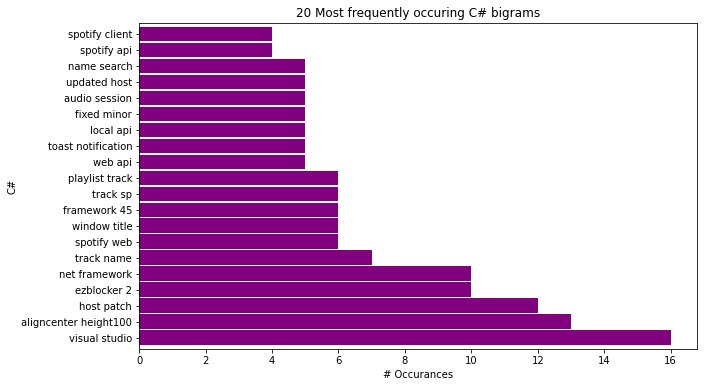

In [20]:
top_20_c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

top_20_c_bigrams.sort_values(ascending=False).plot.barh(color='purple', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C# bigrams')
plt.ylabel('C#')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## Shell

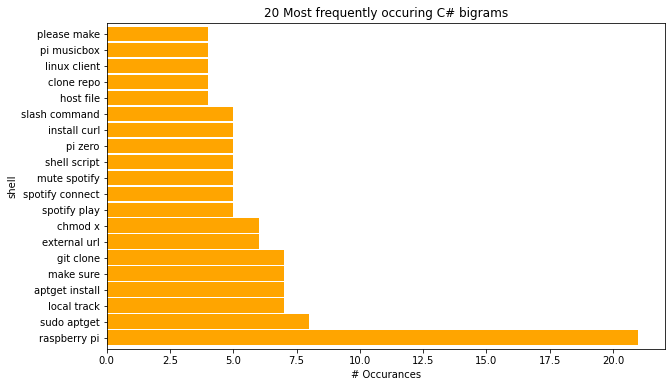

In [21]:
top_20_shell_bigrams = (pd.Series(nltk.ngrams(Shell_words, 2))
                      .value_counts()
                      .head(20))

top_20_shell_bigrams.sort_values(ascending=False).plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C# bigrams')
plt.ylabel('shell')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_shell_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## Exploration Takeaways

__The top 5 Programing languages are__
- JavaScript
- Python
- TypeScript
- Shell
- C#

__The most commonly used top ten words have between 770 and nearly 3000 specific uses, respectively__


__Each of the top 5 programing languages have relatively specific bigrams when looking at most used__

# Modeling

In [22]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df.lemmatized)
y = df.language

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(x_train, y_train)

train['lm_predicted'] = lm.predict(x_train)
test['lm_predicted'] = lm.predict(x_test)

rf = RandomForestClassifier(min_samples_leaf=2).fit(x_train, y_train)

train['rf_predicted'] = rf.predict(x_train)
test['rf_predicted'] = rf.predict(x_test)

sgd = make_pipeline(Normalizer(),
                    SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None))


sgd.fit(x_train, y_train)
train['sgd_predicted'] = sgd.predict(x_train)
test['sgd_predicted'] = sgd.predict(x_test)


| Model | Accuracy (Train) | Accuracy (Test) | Diffrence |
| ---- | ----| ---- |---- |
| Logistic Regression Model | 0.82 | N/A |  N/A |
| Stochastic Gradient Descent (SGD) | 0.97 | N/A | N/A | 
| Random Forest | 0.87 | 0.62| 0.25| 
    


## Logistic Regression Model

### Testing the model on Train

In [23]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print(classification_report(train.actual, train.lm_predicted))

Accuracy: 82.12%
---
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00        22
  JavaScript       0.85      0.95      0.90       226
      Python       0.98      0.87      0.92       155
       Shell       1.00      0.06      0.12        31
  TypeScript       1.00      0.09      0.17        55
       other       0.74      0.98      0.84       283

    accuracy                           0.82       772
   macro avg       0.76      0.49      0.49       772
weighted avg       0.83      0.82      0.77       772



## Stochastic Gradient Descent (SGD)

### Testing the model on Train

In [27]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.sgd_predicted)))
print('---')
print(classification_report(train.actual, train.sgd_predicted))

Accuracy: 97.15%
---
              precision    recall  f1-score   support

          C#       1.00      0.91      0.95        22
  JavaScript       1.00      0.96      0.98       226
      Python       0.88      1.00      0.93       155
       Shell       1.00      0.97      0.98        31
  TypeScript       1.00      0.98      0.99        55
       other       1.00      0.97      0.99       283

    accuracy                           0.97       772
   macro avg       0.98      0.96      0.97       772
weighted avg       0.98      0.97      0.97       772



## Random Forest Classifier

### Testing the model on Train

In [25]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print(classification_report(train.actual, train.rf_predicted))


Accuracy: 87.31%
---
              precision    recall  f1-score   support

          C#       1.00      0.50      0.67        22
  JavaScript       0.92      0.91      0.91       226
      Python       0.99      0.90      0.94       155
       Shell       1.00      0.39      0.56        31
  TypeScript       1.00      0.51      0.67        55
       other       0.78      0.99      0.87       283

    accuracy                           0.87       772
   macro avg       0.95      0.70      0.77       772
weighted avg       0.89      0.87      0.86       772



### Testing the model on Test

In [26]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.rf_predicted)))
print('---')
print(classification_report(test.actual, test.rf_predicted))


Accuracy: 61.66%
---
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         6
  JavaScript       0.71      0.52      0.60        56
      Python       1.00      0.59      0.74        39
       Shell       0.00      0.00      0.00         8
  TypeScript       1.00      0.08      0.14        13
       other       0.52      0.93      0.66        71

    accuracy                           0.62       193
   macro avg       0.54      0.35      0.36       193
weighted avg       0.66      0.62      0.58       193



# Conclusion 

## Key Items

- After testing multiple models, our best performer turned out to be random forest at 62%

- Through exploration we found that each programming language does have its own unique distribution of words

## Recomendations

- For the time being this model should be implemented until a better model can be implemented at a later date

## What's Next?

- With a many model approach based on each language as a target variable we may be able to create a model with much more accuracy at pinpointing select programming languages based on README text.

- through the use of many models we may better be able to make models detect more obscure languages along with the more commonly used ones.